### 演習 14


この演習では，`xenonpy.descriptor`の下に様々な記述子計算モジュールと駆使して，`Materials Project`に収録されているサンプルデータの`形成エネルギー (formation_energy_per_atom)`, `密度 (density)`と`バンドギャップ (band_gap)`をモデルで予測する．`xenonpy.descriptor.Composition`モジュールを利用して，化学式から記述子を計算する．

サンプルデータの取得について，．[retrieve_materials_project](https://nbviewer.org/github/yoshida-lab/XenonPy/blob/master/MI_Book/retrieve_materials_project.ipynb) を参考せよ．

#### 必要なパッケージをimportする

In [1]:
%run common_setting.ipynb

from xenonpy.datatools import preset

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
import matplotlib.ticker as plticker


In [2]:
# 図を描画する関数

def cv_plot(pred, true, pred_fit=None, true_fit=None, *, unit='', lim=None, n_ticks=5, title='', ax=None, color_style=True, show_label=True, show_legend=True, **kwargs):
    pred, true = pred.flatten(), true.flatten()
    scores = regression_metrics(true, pred)

#     with matplotlib.style.context(style):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 8), dpi=150)

    if color_style:
        if pred_fit is not None and true_fit is not None:
            ax.scatter(pred_fit, true_fit, alpha=0.4, s=13, marker='D', label='Train', **kwargs)
        ax.scatter(pred, true, alpha=1, s=35, ec='w', marker='o', label='Test', **kwargs)
    else:
        if pred_fit is not None and true_fit is not None:
            ax.scatter(pred_fit, true_fit, alpha=0.6, s=15, ec='grey', c='none', marker='D', label='Train', **kwargs)
        ax.scatter(pred, true, alpha=1, s=35, ec='w', c='k', marker='o', label='Test', **kwargs)
        
    # adjust lims
    if lim is None:
        temp_data = np.concatenate([pred, true]) if pred_fit is None or true_fit is None else np.concatenate([pred, true, pred_fit, true_fit])
        lim = (temp_data.min(), temp_data.max())
        shift = (lim[1] - lim[0]) * 0.05
        lim = (lim[0] - shift, lim[1] + shift)
    ax.set_xlim(*lim)
    ax.set_ylim(*lim)

    # plot diagonal
    ax.plot(lim, lim, ls="--", c="0.3", alpha=0.7, lw=1.5)
    
    # align ticks
    base = round((lim[1] - lim[0]) / n_ticks)
    loc = plticker.MultipleLocator(base=base) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    
    if unit != '':
        unit = f' ({unit})'
    if show_label:
        ax.set_xlabel(f'Prediction{unit}', fontsize='x-large')
        ax.set_ylabel(f'Observation{unit}', fontsize='x-large')
    if show_legend:
        legend = ax.legend(markerscale=2.5, fontsize='larger', loc=0)
        for lh in legend.legendHandles:
            lh.set_alpha(1.0)
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_title(title, fontsize='xx-large')
    shift = (lim[1] - lim[0]) / 30
    ax.text(lim[1] - shift, lim[0] + shift,
             'R2: %.3f\nMAE: %.3f' % (scores['r2'],scores['mae']),
             horizontalalignment='right', verticalalignment='bottom', fontsize='x-large',
            bbox=dict(boxstyle='square', facecolor='grey', alpha=0.2, ec='black'),
           )
    ax.tick_params(axis='both', which='major', labelsize='larger')
    return ax

#### ターゲットを設定する

In [3]:
props = ['formation_energy_per_atom', 'density', 'band_gap']

In [4]:
stable_data = preset.mp_samples

stable_data.shape
stable_data.head(3)

(2000, 11)

,band_gap,composition,density,e_above_hull,efermi,elements,final_energy_per_atom,formation_energy_per_atom,pretty_formula,structure,volume
mp-1013558,0.0759,"{'Ca': 3.0, 'Bi': 1.0, 'P': 1.0}",3.744327,0,3.359477,"[Ca, Bi, P]",-4.028126,-0.968508,Ca3BiP,"[[0. 2.712928 2.712928] Ca, [2.712928 0....",159.736730
mp-1018025,2.1874,"{'Lu': 1.0, 'Ag': 1.0, 'O': 2.0}",8.244933,0,1.097439,"[Lu, Ag, O]",-6.680209,-2.719007,LuAgO2,"[[9.269319 0. 1.463227] Lu, [0. 0. 0.] A...",63.407935
mp-1019105,0.3778,"{'K': 2.0, 'Mg': 2.0, 'Bi': 2.0}",4.363566,0,2.351814,"[K, Mg, Bi]",-2.668499,-0.470595,KMgBi,"[[0. 2.470566 2.96732902] K, [2.4705...",207.309239


#### データを分割する

In [5]:

from xenonpy.datatools import Splitter

sp = Splitter(len(stable_data), test_size=0.2)

train_idx, test_idx = sp.split(stable_data.index.tolist())
all_idx = np.concatenate([train_idx, test_idx])

train_idx.size
test_idx.size

1600

400

### モデル訓練とテスト

#### 組成記述子とランダムフォレストモデル (random forest)

In [6]:
from xenonpy.descriptor import Compositions

comp_desc = Compositions(n_jobs=5).fit_transform(stable_data)
comp_desc.head(3)

,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,ave:c6_gb,ave:covalent_radius_cordero,ave:covalent_radius_pyykko,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
mp-1013558,31.6,177.800000,256.600000,25.600000,72.037632,1541.400,18.600000,1478.0,156.6,155.0,...,2.0,3.0,0.124,0.23600,180.0,190.0,222.0,339.9,1790.0,3.630
mp-1018025,33.5,152.850710,209.250000,14.025000,78.708250,1583.345,75.053020,598.6,116.0,104.0,...,1.0,2.0,0.155,0.02658,152.0,150.0,182.0,314.8,317.5,0.802
mp-1019105,38.0,188.333333,241.333333,26.866667,90.794567,1431.000,26.366667,1684.0,164.0,162.0,...,1.0,3.0,0.124,8.00000,173.0,251.0,243.0,302.1,1790.0,7.400


In [12]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=250, n_jobs=5).fit(comp_desc.loc[train_idx], stable_data[props].loc[train_idx])

y_pred = rfr.predict(comp_desc.loc[test_idx])
y_pred = pd.DataFrame(y_pred, index=test_idx, columns=[s + '_pred' for s in props])

y_pred_fit = rfr.predict(comp_desc.loc[train_idx])
y_pred_fit = pd.DataFrame(y_pred_fit, index=train_idx, columns=[s + '_pred' for s in props])

results = pd.concat(
    [stable_data[props].loc[all_idx], pd.concat([y_pred_fit, y_pred])],
    axis=1,
    ).assign(label=['Train']*train_idx.size + ['Test']*test_idx.size)
results.head(3)

,formation_energy_per_atom,density,band_gap,formation_energy_per_atom_pred,density_pred,band_gap_pred,label
mp-1205693,-3.666541,7.508622,0.8819,-3.598225,7.431397,1.242942,Train
mp-680170,-1.437522,2.854721,1.1626,-1.437123,2.879369,1.690798,Train
mp-1225159,-3.070471,7.677141,2.1765,-2.931239,7.293774,2.122827,Train


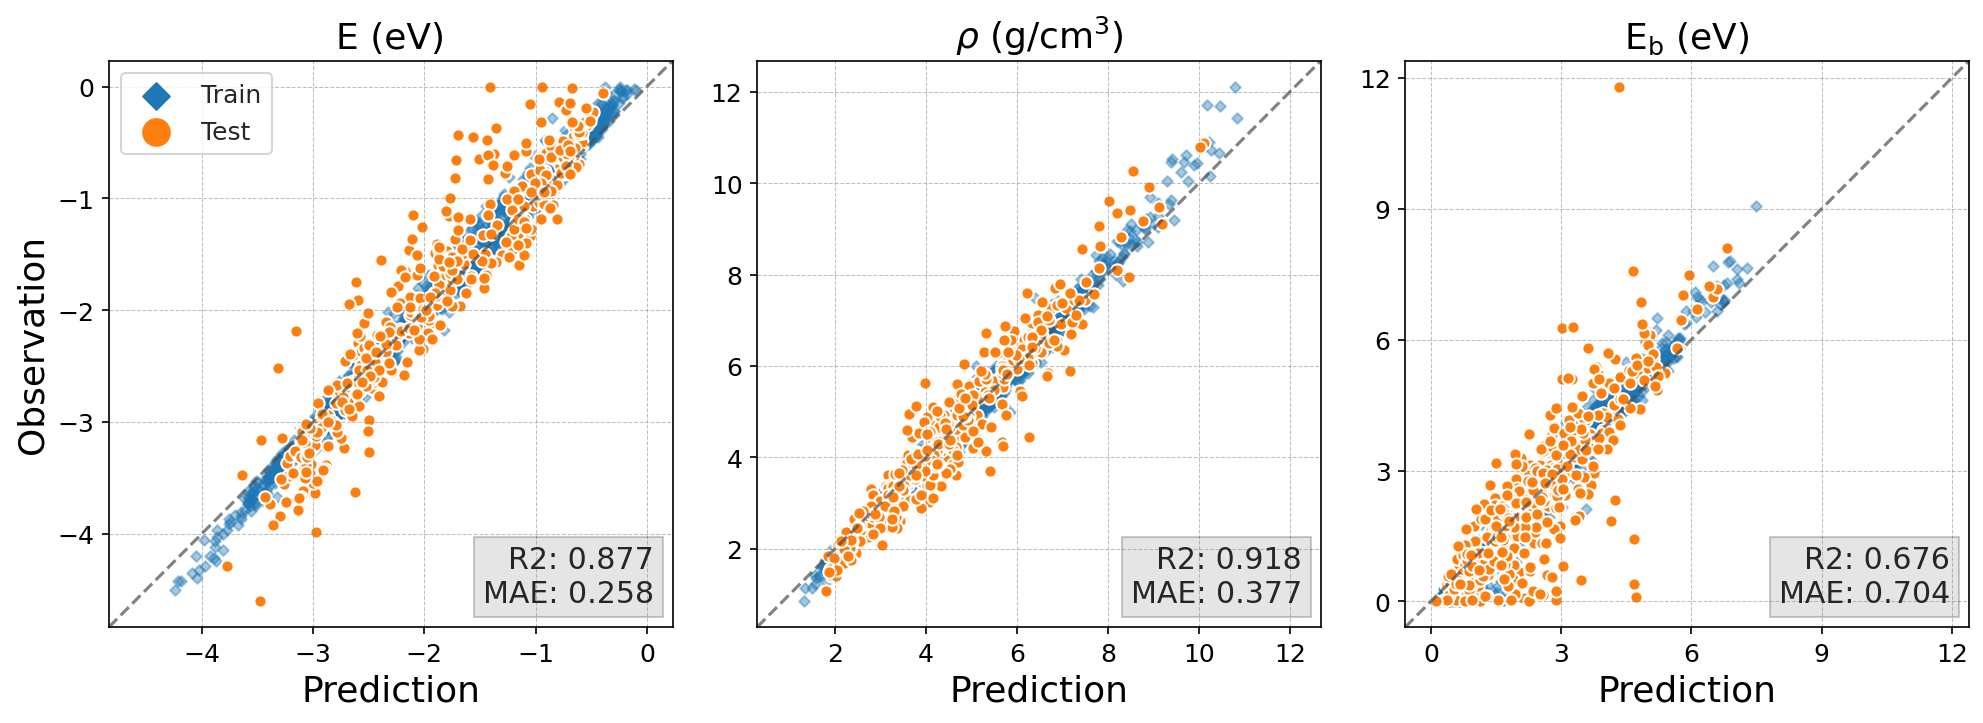

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5), dpi=150)
plt.subplots_adjust(wspace=0.15)

titles = {
    'formation_energy_per_atom': 'E (eV)',
    'density': r"$\rho$ (g/cm$^3$)",
    'band_gap': r"$\mathrm{E}_\mathrm{b}$ (eV)"
}

for i, (prop, ax) in enumerate(zip(props, axs)):
    train_idx, test_idx = results[results.label == 'Train'].index, results[results.label == 'Test'].index
    
    pred = results[prop + '_pred'].loc[test_idx].values
    pred_fit = results[prop + '_pred'].loc[train_idx].values
    
    true = results[prop].loc[test_idx].values
    true_fit = results[prop].loc[train_idx].values
    
    with sns.axes_style("ticks", rc={"lines.linewidth": 13, "axes.labelsize": "large"}):
        ax = cv_plot(pred, true, pred_fit, true_fit,
                     ax=ax, color_style=True, title=titles[prop],
                     show_legend=True if i == 0 else False, show_label=False)
        
        if i == 0:
            _ = ax.set_ylabel('Observation', fontsize='xx-large')
        _ = ax.set_xlabel('Prediction', fontsize='xx-large')

##### 組成+RDF記述子とランダムフォレストモデル (random forest)

In [9]:
%%time

from xenonpy.descriptor import RadialDistributionFunction

rdf_desc = RadialDistributionFunction(n_jobs=5).fit_transform(stable_data.structure)
rdf_desc.head(3)

/Users/liuchang/mambaforge/envs/xepy38/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001,0.8,0.9,1.0,...,19.1,19.200000000000003,19.3,19.400000000000002,19.5,19.6,19.700000000000003,19.8,19.900000000000002,20.0
mp-1013558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,23.293012,0.000000,6.518284,0.000000,7.982000,0.000000,9.385389,0.000000,24.528412
mp-1018025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.839721,4.540557,3.676504,1.212867,4.201498,6.733013,2.352232,3.104630,7.107302,2.662357
mp-1019105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,2.399214,4.748704,4.699748,6.977319,6.906123,6.836011,10.714354,6.140706,8.842617


In [13]:
comp_rdf_desc = pd.concat([comp_desc, rdf_desc], axis=1)
rfr = RandomForestRegressor(n_estimators=250, n_jobs=10).fit(comp_rdf_desc.loc[train_idx], stable_data[props].loc[train_idx])

y_pred = rfr.predict(comp_rdf_desc.loc[test_idx])
y_pred = pd.DataFrame(y_pred, index=test_idx, columns=[s + '_pred' for s in props])

y_pred_fit = rfr.predict(comp_rdf_desc.loc[train_idx])
y_pred_fit = pd.DataFrame(y_pred_fit, index=train_idx, columns=[s + '_pred' for s in props])

results = pd.concat(
    [stable_data[props].loc[all_idx], pd.concat([y_pred_fit, y_pred])],
    axis=1,
    ).assign(label=['Train']*train_idx.size + ['Test']*test_idx.size)
results.head(3)

,formation_energy_per_atom,density,band_gap,formation_energy_per_atom_pred,density_pred,band_gap_pred,label
mp-1205693,-3.666541,7.508622,0.8819,-3.536469,7.379541,1.155328,Train
mp-680170,-1.437522,2.854721,1.1626,-1.427911,2.857600,1.547218,Train
mp-1225159,-3.070471,7.677141,2.1765,-2.919262,7.237301,2.188213,Train


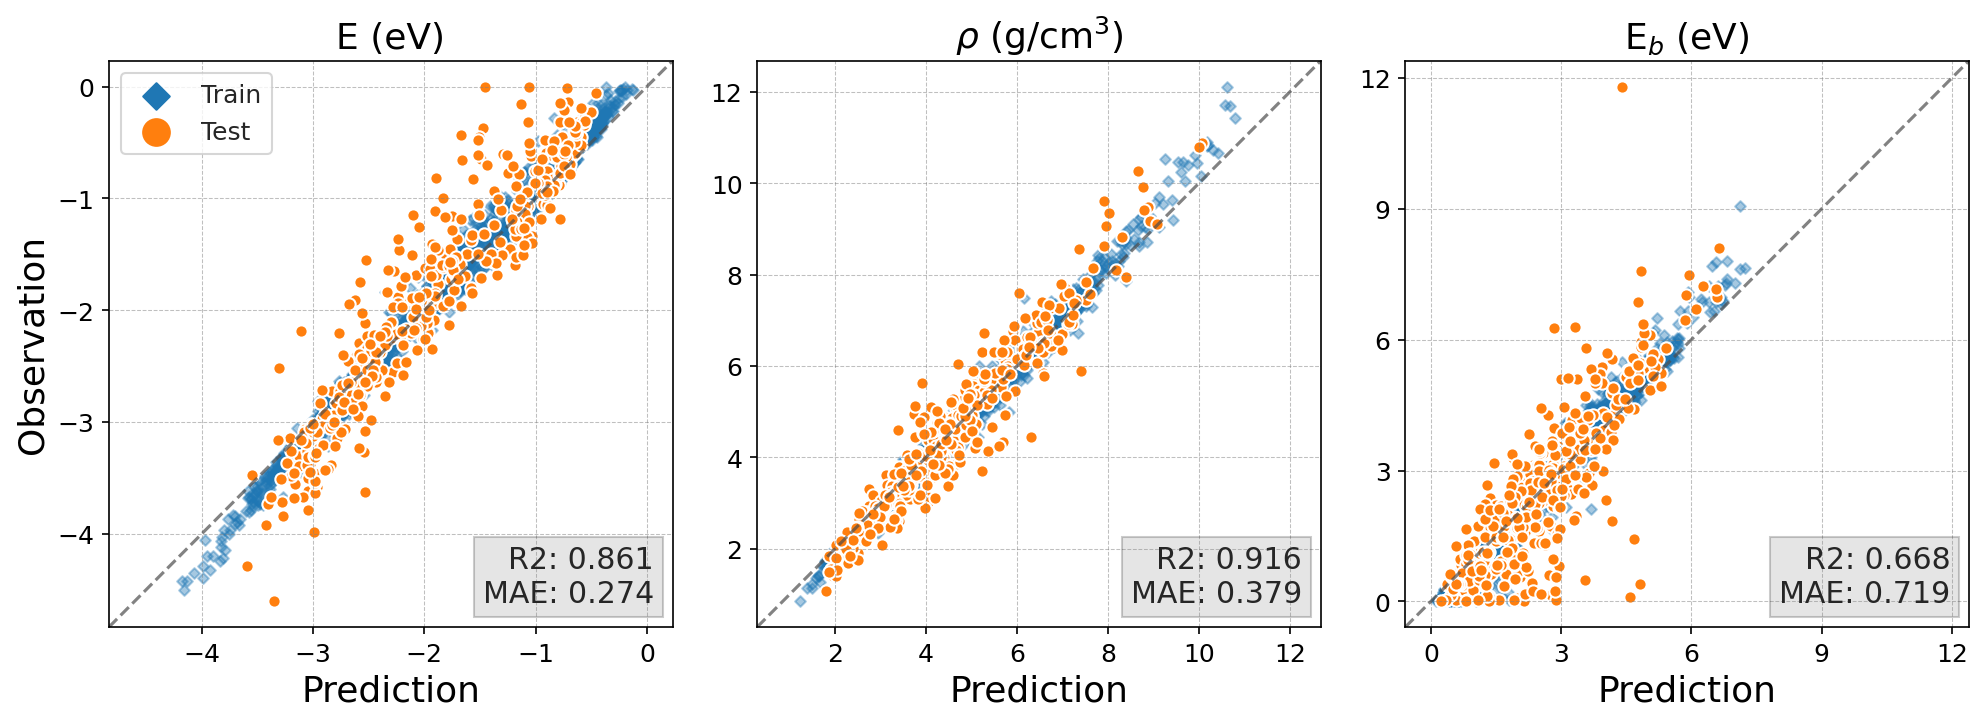

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5), dpi=150)
plt.subplots_adjust(wspace=0.15)

titles = {
    'formation_energy_per_atom': 'E (eV)',
    'density': r"$\rho$ (g/cm$^3$)",
    'band_gap': r"$\mathrm{E}_b$ (eV)"
}

for i, (prop, ax) in enumerate(zip(props, axs)):
    train_idx, test_idx = results[results.label == 'Train'].index, results[results.label == 'Test'].index
    
    pred = results[prop + '_pred'].loc[test_idx].values
    pred_fit = results[prop + '_pred'].loc[train_idx].values
    
    true = results[prop].loc[test_idx].values
    true_fit = results[prop].loc[train_idx].values
    
    with sns.axes_style("ticks", rc={"lines.linewidth": 13, "axes.labelsize": "large"}):
        ax = cv_plot(pred, true, pred_fit, true_fit,
                     ax=ax, color_style=True, title=titles[prop],
                     show_legend=True if i == 0 else False, show_label=False)
        
        if i == 0:
            _ = ax.set_ylabel('Observation', fontsize='xx-large')
        _ = ax.set_xlabel('Prediction', fontsize='xx-large')

#### CGCNN

In [15]:
import torch

from torch.utils.data import DataLoader
from xenonpy.descriptor import Compositions, CrystalGraphFeaturizer
from xenonpy.datatools import Splitter
from itertools import product

from xenonpy.model.utils import regression_metrics
from xenonpy.model.training import Trainer, MSELoss, Adam, ClipValue
from xenonpy.model.training.extension import Validator, TensorConverter
from xenonpy.model.training.dataset import CrystalGraphDataset
from xenonpy.model import CrystalGraphConvNet

In [16]:
# params = [0.01, 0.008, 0.006, 0.004, 0.002]
params = [0.01]
epochs = 400
model_params = {'orig_atom_fea_len': 92,
 'nbr_fea_len': 41,
 'atom_fea_len': 64,
 'n_conv': 4,
 'h_fea_len': 32,
 'n_h': 1}

In [17]:
%%time

### prepare featurizer
cg_featurizer = CrystalGraphFeaturizer(atom_feature='origin', radius=8, n_jobs=20)
cg_features = cg_featurizer.transform(stable_data.structure)

cg_features.head(3)

CPU times: user 5.06 s, sys: 591 ms, total: 5.65 s
Wall time: 26.7 s


,atom_feature,neighbor_feature,neighbor_idx
mp-1013558,"[[tensor(0.), tensor(0.), tensor(1.), tensor(0...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(...","[[tensor(4), tensor(4), tensor(1), tensor(2), ..."
mp-1018025,"[[tensor(0.), tensor(0.), tensor(0.), tensor(1...","[[[tensor(0.), tensor(2.8026e-45), tensor(5.05...","[[tensor(3), tensor(2), tensor(3), tensor(2), ..."
mp-1019105,"[[tensor(0.), tensor(1.), tensor(0.), tensor(0...","[[[tensor(0.), tensor(0.), tensor(0.), tensor(...","[[tensor(5), tensor(5), tensor(5), tensor(5), ..."


In [18]:
## prepare training
x_train, x_test = cg_features.loc[train_idx], cg_features.loc[test_idx]
y_train, y_test = stable_data[props].loc[train_idx], stable_data[props].loc[test_idx]

In [21]:
## set training parameters
import warnings
warnings.filterwarnings('ignore')

cuda = torch.cuda.is_available()  # GPU計算を行うか否か．CPUのみでも計算可能だが，かなり効率が悪い．
summary = []

for prop in props:
    train_dataloader = DataLoader(CrystalGraphDataset(x_train, y_train[[prop]]), shuffle=True,
                                  batch_size=2000, collate_fn=CrystalGraphDataset.collate_fn)
    val_dataloader = DataLoader(CrystalGraphDataset(x_test, y_test[[prop]]), shuffle=False,
                                  batch_size=2000, collate_fn=CrystalGraphDataset.collate_fn)
    
    ## training
    for lr, clip in product(params, params):
        model = CrystalGraphConvNet(**model_params)

        trainer = Trainer(
            model=model,
            cuda=cuda,
            optimizer=Adam(lr=lr),
            loss_func=MSELoss(),
            clip_grad=ClipValue(clip)
        ).extend(
            TensorConverter(empty_cache=True),
            Validator(metrics_func=regression_metrics, early_stopping=20, trace_order=5, pearsonr=1.0, mse=0.0, r2=0.0, mae=0.0),
        )

        print(f"====== lr: {lr}; clip: {clip} ===========")
        trainer.fit(training_dataset=train_dataloader, validation_dataset=val_dataloader, epochs=epochs, checkpoint=True)
    
        training_info = trainer.training_info

        # draw OvP
        y_pred, y_true = trainer.predict(dataset=val_dataloader, checkpoint='mae_1')
        y_pred_fit, y_true_fit = trainer.predict(dataset=train_dataloader, checkpoint='mae_1')

        pred, true = np.concatenate([y_pred, y_pred_fit]), np.concatenate([y_true, y_true_fit])
        results = pd.DataFrame({prop: true.ravel(), f'{prop}_pred': pred.ravel()})
        summary.append(results)

results = pd.concat(summary, axis=1).assign(label=['Train']*train_idx.size + ['Test']*test_idx.size)

====== lr: 0.01; clip: 0.01 ===========


Training:   0%|          | 0/400 [00:00<?, ?it/s]

====== lr: 0.01; clip: 0.01 ===========


Training:   0%|          | 0/400 [00:00<?, ?it/s]

====== lr: 0.01; clip: 0.01 ===========


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Early stopping is applied: no improvement for ['pearsonr', 'mse', 'r2', 'mae'] since the last 21 iterations, finish training at iteration 308


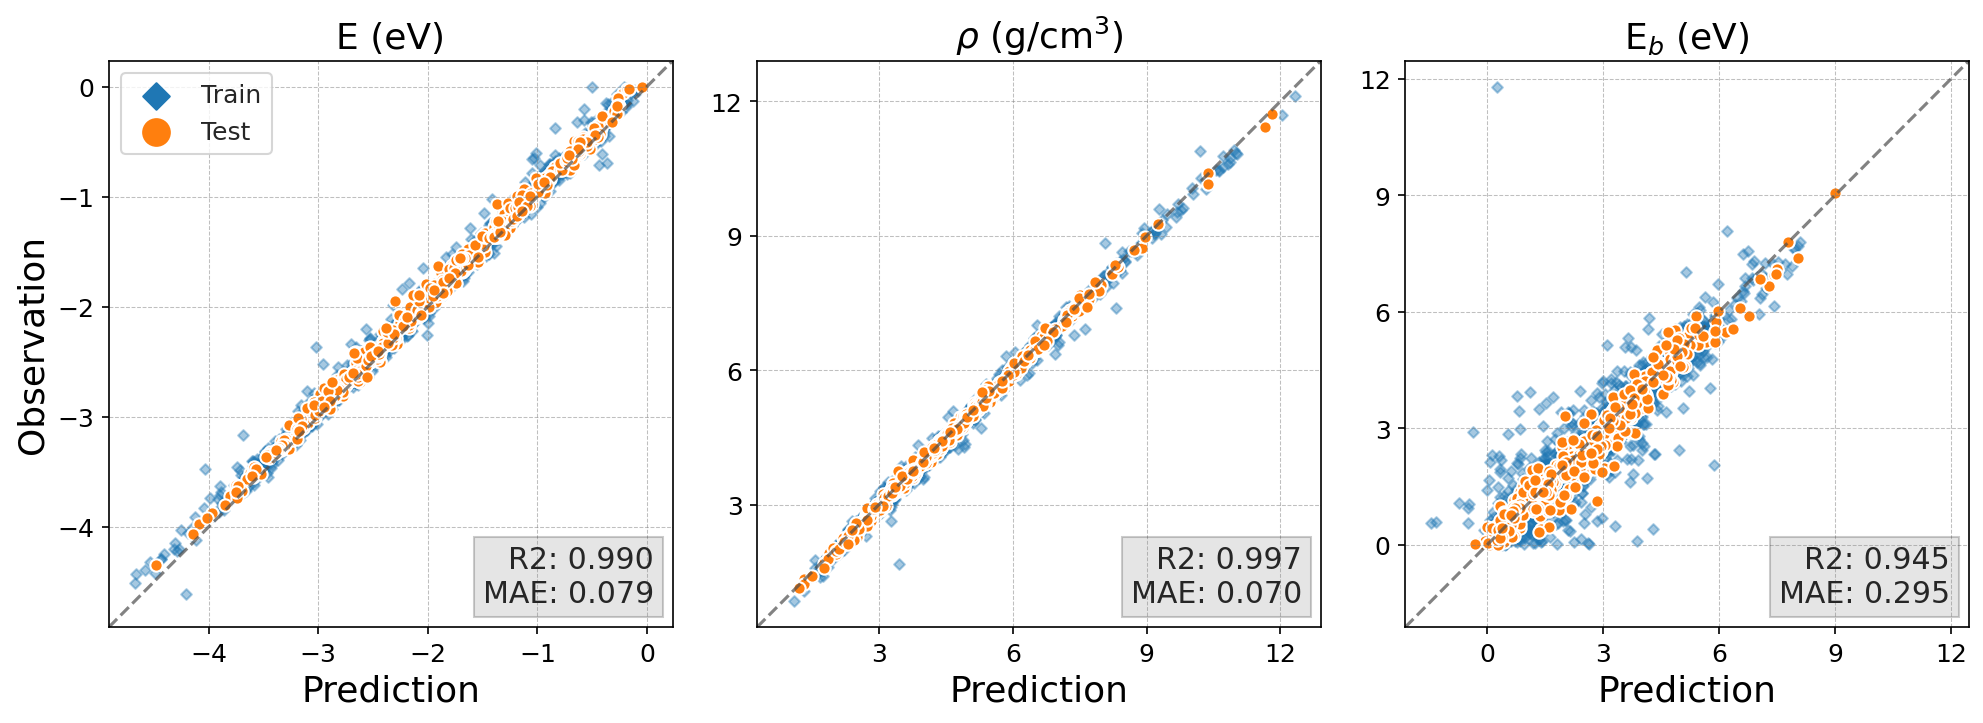

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5), dpi=150)
plt.subplots_adjust(wspace=0.15)

titles = {
    'formation_energy_per_atom': 'E (eV)',
    'density': r"$\rho$ (g/cm$^3$)",
    'band_gap': r"$\mathrm{E}_b$ (eV)"
}

for i, (prop, ax) in enumerate(zip(props, axs)):
    train_idx, test_idx = results[results.label == 'Train'].index, results[results.label == 'Test'].index
    
    pred = results[prop + '_pred'].loc[test_idx].values
    pred_fit = results[prop + '_pred'].loc[train_idx].values
    
    true = results[prop].loc[test_idx].values
    true_fit = results[prop].loc[train_idx].values
    
    with sns.axes_style("ticks", rc={"lines.linewidth": 13, "axes.labelsize": "large"}):
        ax = cv_plot(pred, true, pred_fit, true_fit,
                     ax=ax, color_style=True, title=titles[prop],
                     show_legend=True if i == 0 else False, show_label=False)
        
        if i == 0:
            _ = ax.set_ylabel('Observation', fontsize='xx-large')
        _ = ax.set_xlabel('Prediction', fontsize='xx-large')